# Parnian Taheri - 99106352

In [ ]:
# Feel free to import any other libraries and modules.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

# Part One: Optimization Algorithms
## 1. Gradient Descent
The Gradient Descent (GD) algorithm finds the minimum of a given
function by taking small steps along the function's gradient:

>$\Theta \leftarrow \Theta_0$

>**while** stop condition not met **do**

>$~~~~$$\Theta \leftarrow \Theta - \alpha \nabla_\Theta f(\Theta)$

>**end while**

where $f$ is the function to minimize, $\nabla_\Theta f(\Theta)$
denotes $f$'s gradient at $\Theta$ and $\alpha$ is the learning rate.

**Task1:** Implement the GD algorithm as a function:

  \begin{equation}
      \Theta_{opt} = \text{GD}(f, \Theta_0, \alpha, \rho)
  \end{equation}
where $f$ is a function returning the cost and its gradient with respect to parameter vector $\Theta$, $\Theta_0$ is the initial value, and $\alpha$
is the learning rate. You can assume that $\alpha$. remains constant during the optimization. $\rho$ is stop condition. \\
Then, use the GD algorithm to find the optimum of the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function) (Consider $a=1, b=100$).
 \\
Also, plot the values found by GD at subsequent iterations.

## 2. Newton's Method
Newton's method is an iterative optimization algorithm used to find the minimum of a function.
The basic update step in Newton's method is given by:

\begin{equation}
\Theta = \Theta - H^{-1} \cdot \nabla f(\Theta)
\end{equation}


Where  $ H $ is the Hessian matrix of the function at $ \Theta $, and $ H^{-1} $ is the inverse of the Hessian matrix, used to adjust the step size and direction more accurately than just using the gradient alone (as done in gradient descent).

#### Line Search
Sometimes, Newton's method may take too large of a step, which can lead to divergence. To prevent this, a simple **line search** is used. This reduces the step size $ \alpha $ if the function value doesn't improve after the step.

Steps:
1. Compute the gradient and Hessian matrix at the current point.
2. Calculate the step direction by multiplying the inverse of the Hessian with the gradient.
3. Update the point by subtracting the step from the current point.
4. If the function value doesn't improve, reduce the step size $ \alpha $.
5. Repeat until the gradient becomes sufficiently small (close to zero), indicating convergence.



**Task2:** Implement Newton's method and compare it with the gradient descent. You will also need to implement a line search alogithm, e.g. (https://en.wikipedia.org/wiki/Backtracking_line_search) and make sure that the Newton's direction is indeed one along which the function is minimized.


In [ ]:
def rosenbrock(x):
    """Returns the value and gradient of Rosenbrock's function at x: 2d vector"""
    a = 1
    b = 100
    val = (a - x[0])**2 + b * (x[1] - x[0]**2)**2
    dv_dx0 = -2*(a - x[0]) - 4*b*(x[1] - x[0]**2)*x[0]
    dv_dx1 = 2*b*(x[1] - x[0]**2)
    grad = np.array([dv_dx0, dv_dx1])
    return val, grad

def rosenbrock_hessian(x):
    """Returns the value, gradient and hessian of Rosenbrock's function at x: 2d vector"""
    val, grad = rosenbrock(x)
    a = 1
    b = 100
    # Hessian matrix components
    d2v_dx0x0 = 2 - 4*b*x[1] + 12*b*x[0]**2
    d2v_dx0x1 = 4*b*x[0]
    d2v_dx1x0 = -4*b*x[0]
    d2v_dx1x1 = 2*b

    # Hessian matrix
    hessian = np.array([[d2v_dx0x0, d2v_dx0x1],
                [d2v_dx1x0, d2v_dx1x1]])

    return val, grad, hessian


def GD(f, theta0, alpha, stop_tolerance=1e-10, max_steps=1000000):
    """Runs gradient descent algorithm on f.

    Args:
        f: function that when evaluated on a Theta of same dtype and shape as Theta0
            returns a tuple (value, dv_dtheta) with dValuedTheta of the same shape
            as Theta
        theta0: starting point
        alpha: step length
        stop_tolerance: stop iterations when improvement is below this threshold
        max_steps: maximum number of steps
    Returns:
        tuple:
        - theta: optimum theta found by the algorithm
        - history: list of length num_steps containing tuples (theta, (val, dv_dtheta: np.array))

    """
    history = []

    theta = theta0


    step = 0
    while step < max_steps:
      val, grad = f(theta)
      theta = theta - alpha * grad
      if np.linalg.norm(grad) < stop_tolerance:
           break
      step += 1

      history.append([theta, f(theta)])
    return theta, history

Found optimum at [1. 1.] in 54319 steps (true minimum is at [1,1])


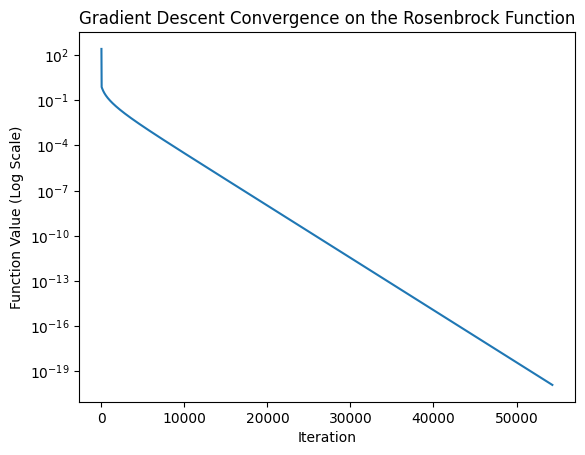

In [ ]:
# Find the optimum of rosenbrock function

X0 = [0.,2.]
Xopt, Xhist = GD(rosenbrock, X0, alpha=1e-3, stop_tolerance=1e-10, max_steps=1e6)

print ("Found optimum at %s in %d steps (true minimum is at [1,1])" % (Xopt, len(Xhist)))

# Extract the function values for plotting
function_values = [val[0] for _, val in Xhist]
plt.plot(function_values)
plt.xlabel("Iteration")
plt.ylabel("Function Value (Log Scale)")
plt.yscale("log")
plt.title("Gradient Descent Convergence on the Rosenbrock Function")
plt.show()

Found optimum at [1. 1.] in 84867 steps (true minimum is at [1,1])


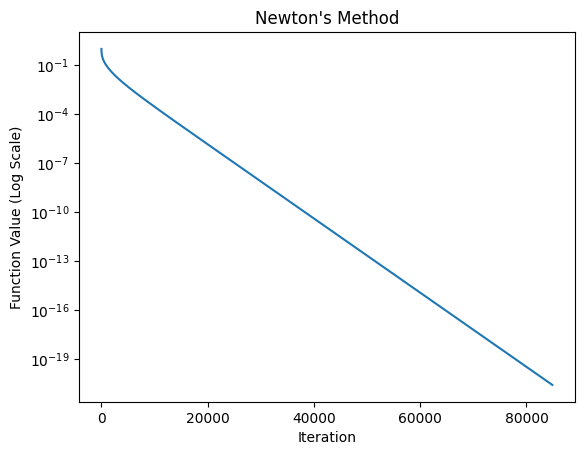

In [ ]:
# Newton's Method
def Newton(f, theta0, alpha=1, stop_tolerance=1e-10, max_steps=1000000):
    """Performs Newton's optimization method with a simple line search.

    Args:
        f: function that when evaluated on a Theta of same dtype and shape as Theta0
            returns a tuple (value, gradient, hessian), where gradient and Hessian
            have the same shape as Theta.
        theta0: starting point.
        alpha: step length for backtracking line search (default is 1).
        stop_tolerance: stop iterations when the norm of the gradient is below this threshold.
        max_steps: maximum number of iterations.
    Returns:
        tuple:
        - theta: optimal Theta after convergence or maximum steps.
        - history: list of tuples (theta, value, gradient) containing the optimization path.
    """
    theta = theta0
    history = []
    # TODO
    step = 0
    rho = 0.8
    c = 1e-4 #Armijo condition constant (0 < c < 1).
    while step < max_steps:
      val, grad, hessian  = f(theta)

      if np.linalg.norm(grad) < stop_tolerance:
           break

      step_direction = -np.linalg.solve(hessian, grad)

      # line search
      while True:
        new_theta = theta + alpha * step_direction
        new_value, _, _ = f(new_theta)

        # Armijo condition
        if new_value <= val + c * alpha * np.dot(grad, step_direction):
            break
        alpha *= rho


      theta += alpha * step_direction

      history.append([theta, f(theta)])

      step += 1
    return theta, history


    return theta, history

# Test Newton's method on the Rosenbrock function
X0 = [0., 2.]  # Initial guess
Xopt, Xhist = Newton(rosenbrock_hessian, X0)

print ("Found optimum at %s in %d steps (true minimum is at [1,1])" % (Xopt, len(Xhist)))

# Extract the function values for plotting
function_values = [val[0] for _, val in Xhist]
plt.plot(function_values)
plt.xlabel("Iteration")
plt.ylabel("Function Value (Log Scale)")
plt.yscale("log")
plt.title("Newton's Method")
plt.show()

With the Newton's method we can get the result but it is slower than Gradient Descent method.

# Part two: MLP for MNIST Classification
In this part, we are going to use `PyTorch`. If you want to become more familiar with it, check this resource: https://www.learnpytorch.io/

#### In this homework, you need to
- implement SGD optimizer (`./optimizer.py`)
- implement forward and backward for FCLayer (`layers.py`)
- implement forward and backward for SigmoidLayer (`layers.py`)
- implement forward and backward for ReLULayer (`layers.py`)
- implement forward and backward for DropoutLayer (`layers.py`)
- implement train and test process (`solver.py`)

In [8]:
# Feel free to import any other libraries and modules.
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

In [9]:
from layers import FCLayer, SigmoidLayer, ReLULayer
from solver import train, test
from optimizer import SGD

In [10]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
# Load MNIST dataset

# Converts PIL image to tensor and scales to [0, 1] and flatten it
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),
])

# Load MNIST dataset with the defined transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# One-hot encoding for labels
def decode_label(label, num_classes=10):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# Preprocess labels and combine with transformed images
y_train = [decode_label(label) for _, label in train_dataset]
y_test = [decode_label(label) for _, label in test_dataset]

# Convert the data into tensor datasets for training and testing
train_dataset = TensorDataset(torch.stack([img for img, _ in train_dataset]), torch.stack(y_train))
test_dataset = TensorDataset(torch.stack([img for img, _ in test_dataset]), torch.stack(y_test))

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
num_epoch = 20

criterion = nn.MSELoss()

# Build MLP with FCLayer and SigmoidLayer you've implemented in layers.py
sigmoidMLP = nn.Sequential(
    FCLayer(784, 128),
    SigmoidLayer(),
    FCLayer(128, 10)
)

# Initialize optimizer you've implemented in optimizer.py
sgd = SGD(params=sigmoidMLP.parameters(), learning_rate=0.01)

# Train the model using train function you've implemented in solver.py
sigmoidMLP = train(sigmoidMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.0771, Average training accuracy: 49.5583

Epoch [1] Average training loss: 0.0556, Average training accuracy: 73.7800

Epoch [2] Average training loss: 0.0506, Average training accuracy: 78.3550

Epoch [3] Average training loss: 0.0482, Average training accuracy: 80.4600

Epoch [4] Average training loss: 0.0466, Average training accuracy: 81.7267

Epoch [5] Average training loss: 0.0456, Average training accuracy: 82.5433

Epoch [6] Average training loss: 0.0448, Average training accuracy: 83.0700

Epoch [7] Average training loss: 0.0442, Average training accuracy: 83.4383

Epoch [8] Average training loss: 0.0437, Average training accuracy: 83.8400

Epoch [9] Average training loss: 0.0432, Average training accuracy: 84.0783

Epoch [10] Average training loss: 0.0429, Average training accuracy: 84.3000

Epoch [11] Average training loss: 0.0426, Average training accuracy: 84.5500

Epoch [12] Average training loss: 0.0423, Average training accuracy: 84.6

In [ ]:
# Test your model using test function you've implemented in solver.py
test(sigmoidMLP, test_dataloader, device)

The test accuracy is 86.2720.



In [12]:
# Build MLP with FCLayer and ReLULayer
reluMLP = nn.Sequential(
    FCLayer(784, 128),
    ReLULayer(),
    FCLayer(128, 10)
)

# Initialize optimizer
sgd = SGD(reluMLP.parameters(), learning_rate=0.01)

# Train the model
reluMLP = train(reluMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.0716, Average training accuracy: 62.6683

Epoch [1] Average training loss: 0.0471, Average training accuracy: 81.1983

Epoch [2] Average training loss: 0.0400, Average training accuracy: 85.2000

Epoch [3] Average training loss: 0.0358, Average training accuracy: 87.1133

Epoch [4] Average training loss: 0.0329, Average training accuracy: 88.2983

Epoch [5] Average training loss: 0.0307, Average training accuracy: 89.1933

Epoch [6] Average training loss: 0.0290, Average training accuracy: 89.8633

Epoch [7] Average training loss: 0.0277, Average training accuracy: 90.3967

Epoch [8] Average training loss: 0.0265, Average training accuracy: 90.8233

Epoch [9] Average training loss: 0.0255, Average training accuracy: 91.1467

Epoch [10] Average training loss: 0.0247, Average training accuracy: 91.4717

Epoch [11] Average training loss: 0.0239, Average training accuracy: 91.7233

Epoch [12] Average training loss: 0.0233, Average training accuracy: 91.9

In [13]:
# Test the model
test(reluMLP, test_dataloader, device)

The test accuracy is 93.4804.



### Overfit the model
Try to overfit the reluMLP model. You can make the model as complex as you like, use subset of the data for training or any other approach you want.
Then add **DropoutLayer** to your model in order to reduce overfitting problem.

In [17]:
#TODO: overfit the reluMLP model
from torch.utils.data import Subset
subset_indices = list(range(50))  # Use only 50 samples for overfitting
train_subset = Subset(train_dataset, subset_indices)

# Create DataLoaders
train_dataloader = DataLoader(train_subset, batch_size=5, shuffle=True)  # Small batch size
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Build MLP with FCLayer and ReLULayer
reluMLP = nn.Sequential(
    FCLayer(784, 512),
    ReLULayer(),
    FCLayer(512, 256),
    ReLULayer(),
    FCLayer(256, 128),
    ReLULayer(),
    FCLayer(128, 10)
)

# Initialize optimizer
sgd = SGD(reluMLP.parameters(), learning_rate=0.01)

# Train the model
reluMLP = train(reluMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.1439, Average training accuracy: 12.0000

Epoch [1] Average training loss: 0.1192, Average training accuracy: 16.0000

Epoch [2] Average training loss: 0.1050, Average training accuracy: 20.0000

Epoch [3] Average training loss: 0.0960, Average training accuracy: 26.0000

Epoch [4] Average training loss: 0.0897, Average training accuracy: 40.0000

Epoch [5] Average training loss: 0.0846, Average training accuracy: 42.0000

Epoch [6] Average training loss: 0.0807, Average training accuracy: 48.0000

Epoch [7] Average training loss: 0.0772, Average training accuracy: 50.0000

Epoch [8] Average training loss: 0.0742, Average training accuracy: 54.0000

Epoch [9] Average training loss: 0.0714, Average training accuracy: 58.0000

Epoch [10] Average training loss: 0.0688, Average training accuracy: 58.0000

Epoch [11] Average training loss: 0.0665, Average training accuracy: 62.0000

Epoch [12] Average training loss: 0.0644, Average training accuracy: 68.0

In [18]:
# Test your model using test function you've implemented in solver.py
test(reluMLP, test_dataloader, device)

The test accuracy is 38.6482.



In [21]:
from layers import DropoutLayer

#TODO: add DropoutLayer to your model
reluMLP = nn.Sequential(
    FCLayer(784, 512),
    ReLULayer(),
    DropoutLayer(0.5),
    FCLayer(512, 256),
    ReLULayer(),
    DropoutLayer(0.5),
    FCLayer(256, 128),
    ReLULayer(),
    DropoutLayer(0.5),
    FCLayer(128, 10)
)

# Initialize optimizer
sgd = SGD(reluMLP.parameters(), learning_rate=0.01)

# Train the model
reluMLP = train(reluMLP, criterion, sgd, train_dataloader, num_epoch, device=device)


Epoch [0] Average training loss: 0.5423, Average training accuracy: 8.0000

Epoch [1] Average training loss: 0.3831, Average training accuracy: 12.0000

Epoch [2] Average training loss: 0.3081, Average training accuracy: 16.0000

Epoch [3] Average training loss: 0.2414, Average training accuracy: 14.0000

Epoch [4] Average training loss: 0.2372, Average training accuracy: 10.0000

Epoch [5] Average training loss: 0.2158, Average training accuracy: 8.0000

Epoch [6] Average training loss: 0.2397, Average training accuracy: 0.0000

Epoch [7] Average training loss: 0.1888, Average training accuracy: 8.0000

Epoch [8] Average training loss: 0.1747, Average training accuracy: 14.0000

Epoch [9] Average training loss: 0.1816, Average training accuracy: 18.0000

Epoch [10] Average training loss: 0.1622, Average training accuracy: 10.0000

Epoch [11] Average training loss: 0.1727, Average training accuracy: 16.0000

Epoch [12] Average training loss: 0.1619, Average training accuracy: 14.0000


In [22]:
# Test your model using test function you've implemented in solver.py
test(reluMLP, test_dataloader, device)

The test accuracy is 15.0359.



Without the Dropout layer, the training accuracy is 90% but the test accuracy is 30%, which is the result of overfitting. However, by adding dropout layer, both the train and test accuracy increases with the same pace, avoiding overfitting.